## 1. Import libraries and Custom Functions

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
plt.rcParams['figure.figsize']=(12,3)

In [6]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [8]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [9]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

## 2. Load and Explore Data

In [ ]:
## Load the data
fname =''
df = pd.read_csv(fname,
                 # use args below if know datetime column already
#                 parse_dates=[''], index_col="" 
                )
df

In [ ]:
# make sure index is datetime index

In [ ]:
​# Select time series to model.
col = '' # if a dataframe
ts = df[col]
ts

In [ ]:
​# check frequency
ts.index

In [ ]:
# resample to desired frequency
# ts = ts.resample(...)..agg()
# ts

In [ ]:
# Visualize selected time series
ax = ts.plot()

## 3. Handle Missing Values

In [ ]:
# Check for null values
ts.isna().sum()

In [ ]:
## Impute null values (if any)
# ts = ts.fillna(0)
# ts = ts.interpolate()
# ts = ts.fillna(method='ffill')
# ts = ts.fillna(method='bfill')

## 4. Determine if a seasonal or non-seasonal model is appropriate for the data

In [ ]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

In [ ]:
# zooming in on smaller time period to see length of season
# decomp.seasonal.loc["...":].plot();

## 5. Check Stationarity and determine differencing (d and D)

In [ ]:
# Check for stationarity
get_adfuller_results(ts)

In [ ]:
# Determine differencing
d = ndiffs(ts)
print(f'd is {d}')
D = nsdiffs(ts, m = _)
print(f'D is {D}')

In [ ]:
# For example, one non seasonal differencing
​ts_diff = ts.diff().dropna() # ts_diff2 = ts.diff().diff().dropna()

## 6. Check Autocorrelation and Partial Autocorrelation to determine initial orders

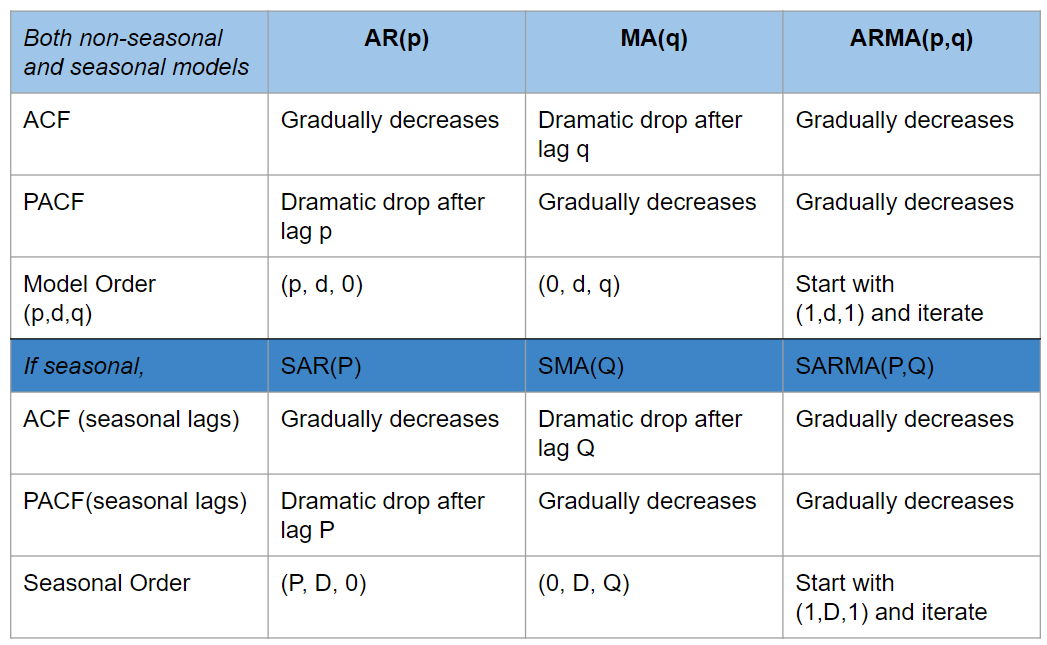

In [ ]:
​plot_acf_pacf(ts_diff, annotate_seas=True, m = _);

## 7. Split into Training and Test Sets

In [ ]:
from pmdarima.model_selection import train_test_split
train, test = train_test_split(ts, test_size=___)
​
​## Visualize train-test-split
ax = train.plot(label="train")
test.plot(label="test")
ax.legend();

## 8. Define the Time Series Model Orders and Fit the model to the training data

In [ ]:
# Orders for non seasonal components
p = _  # nonseasonal AR
d = _  # nonseasonal differencing
q = _ # nonseasonal MA

# Orders for seasonal components (if seasonal model)
P = _  # Seasonal AR
D = _  # Seasonal differencing
Q = _  # Seasonal MA
m = _ # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [ ]:
# Obtain summary
sarima.summary()

In [ ]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## 9. Generate and Visualize Forecasts

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 50)

## 10. Evaluate Model Performance

In [ ]:
regression_metrics_ts(test, forecast_df["forecast"])

## 11. Iterate as Needed

- Manually fit other models
- Loop through variations of the model
- Use pmdarima's auto_arima

## 12. Grid Search Orders with pmdarima

In [ ]:
import pmdarima as pm
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=___,  # True or False
    m=____,  # if seasonal
    trace=True
)

## 13. Fit Statsmodels SARIMA Model Using the Parameters from auto_arima

In [ ]:
# Try auto_arima orders
sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

# Obtain summary
sarima.summary()

## 14. Select and justify the final model

### ​Consider the summary, diagnostic plots, AIC, BIC, and regression metrics. 

## 15. Fit a final model on the entire time series

In [ ]:
final_p = "?"
final_q = "?"
final_d = "?"
final_P = "?"
final_Q = "?"
final_D = "?"
​
​final_model = tsa.ARIMA(
    ts,
    order=(final_p, final_d, final_q),
    seasonal_order=(final_P, final_D, final_Q, m),
).fit()

## 16. Generate and Visualize Future Forecasts

In [ ]:
# Ger forecast into true future (fit on entrie time series)
forecast_df = final_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df, n_train_lags = 20);

## 17. Calculate Summary Metrics for Stakeholder

In [ ]:
# Define starting and final values
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
# Change in x
delta = final_value - starting_value
print(f'The change in X over the forecast is {delta: .2f}.')
perc_change = (delta/starting_value) *100
print (f'The percentage change is {perc_change :.2f}%.')

# Summary

### Remember that selecting the appropriate model depends on the characteristics of your specific time series data, and it may require iterations and adjustments to achieve the best results.​